# DSPy Tutorial
🎬 YouTube *Maxime Rivest* [DSPy Tutorial | Build AI Agents with Python (Fundamentals)](https://www.youtube.com/watch?v=fXjCleTYUm8)

## Basics

In [1]:
import os

import datar.base as b
import dspy
from IPython.display import HTML
from attachments.dspy import Attachments
from datar import f
from datar.dplyr import mutate, summarise, n
from datar.tibble import tibble
from dotenv import load_dotenv

load_dotenv()

True

- DSPy uses [LiteLLM](https://www.litellm.ai/) &rarr; regard that library's documentation as well
- Messages and context and prompts are cached, i.e., same context and prompt and message will be read from cache.

In [2]:
lm_qwen3 = dspy.LM("ollama_chat/qwen3:1.7b")
lm_gpt41 = dspy.LM("gpt-4.1-nano")
dspy.configure(lm=lm_gpt41)

In [3]:
lm_gpt41("hello")

['Hello! How can I assist you today?']

In [4]:
rag = dspy.ChainOfThought("context, question -> answer")

In [5]:
r = rag(context="It's 4 o'clock", question="What time is it?")

In [6]:
r

Prediction(
    reasoning="The context states that it is 4 o'clock, which indicates the current time. The question asks for the time, which directly corresponds to the information provided in the context.",
    answer="It is 4 o'clock."
)

In [7]:
r.answer

"It is 4 o'clock."

In [8]:
with dspy.context(lm=lm_qwen3):
    r = rag(context="It's 4 o'clock", question="What time is it?")
    print(r)
    print(r.answer)

Prediction(
    reasoning="The context explicitly states that it's 4 o'clock. Therefore, the answer is directly derived from the given information.",
    answer="4 o'clock"
)
4 o'clock


## Program 2: Processing Images

In [9]:
weight_extractor = dspy.ChainOfThought("picture -> weight")

[Attachments([jpg(80chars, 1imgs, img: data:image/png;base64,iVBORw0K...lFTkSuQmCC)])]


[Attachments] Running primary processor 'image_to_llm' for ./data/istockphoto-185251506-612x612.jpg
[Attachments]   Applying step 'load.url_to_response' to ./data/istockphoto-185251506-612x612.jpg
[Attachments]   Applying step 'modify.morph_to_detected_type' to ./data/istockphoto-185251506-612x612.jpg
[Attachments]   Applying step 'load.image_to_pil' to ./data/istockphoto-185251506-612x612.jpg
[Attachments]   Applying step 'modify.watermark' to ./data/istockphoto-185251506-612x612.jpg
[Attachments]     Accessing command: 'watermark' = 'auto'
[Attachments]   Running AdditivePipeline(present.images + present.metadata)
[Attachments]     Applying additive step 'present.images' to ./data/istockphoto-185251506-612x612.jpg
[Attachments]     Applying additive step 'present.metadata' to ./data/istockphoto-185251506-612x612.jpg
[Attachments]   Applying step 'refine.resize_images' to ./data/istockphoto-185251506-612x612.jpg



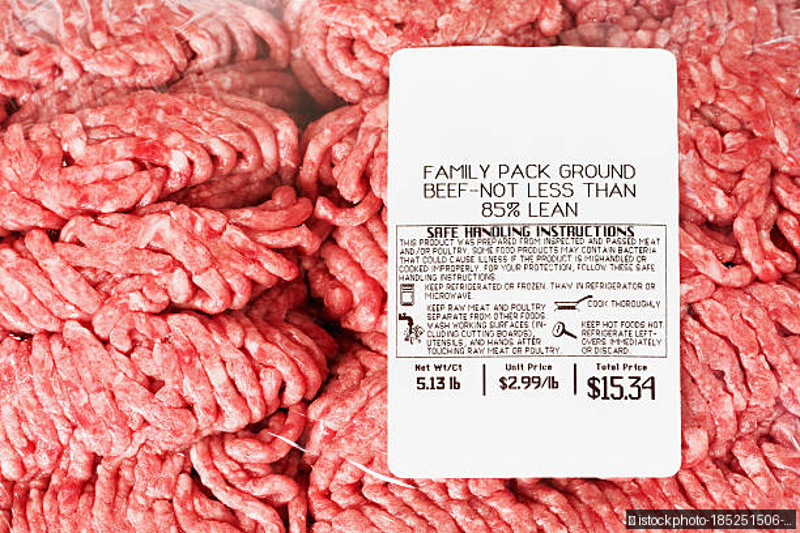

In [10]:
directory = "./data/"

att_list = []
for file in os.listdir(directory)[:2]:
    att_list.append(Attachments(directory + file))
print(att_list)

HTML(f"<img src='{att_list[0].images[0]}' width='200'>")

In [11]:
weight_extractor(picture=att_list[0])

Prediction(
    reasoning='The image shows ground beef, which is typically weighed in pounds or kilograms. The label indicates a net weight of 5.13 pounds, which is a common weight for packaged ground beef sold in stores. Since the label explicitly states the weight, I will use that information directly.',
    weight='5.13 lb'
)

In [12]:
weight_extractor = dspy.ChainOfThought("picture -> weight: float")

In [13]:
weight_extractor(picture=att_list[0])

Prediction(
    reasoning='The image shows ground beef, which is typically weighed in pounds. The label indicates a net weight of 5.13 pounds, which is a common way to specify the weight of packaged meat. Since the task is to produce a weight value based on the image, the most relevant and accurate figure from the label is 5.13 pounds.',
    weight=5.13
)

In [14]:
weight_extractor = dspy.ChainOfThought("picture -> weight: int")

In [15]:
weight_extractor(picture=att_list[0])

Prediction(
    reasoning='The image shows a package of ground beef with a label indicating the weight as 5.13 pounds. Since the task is to produce a weight value based on the image, the most relevant and directly provided information is the weight on the label, which is 5.13 pounds. Therefore, the weight to be reported is 5.13.',
    weight=5
)

In [16]:
signature = dspy.Signature(
    "picture -> weight: float",
    instructions="extract the weight",
)

In [17]:
class weight_signature(dspy.Signature):
    """Extract weight from picture"""
    picture = dspy.InputField(desc="Meat label picture")
    weight: float = dspy.OutputField(desc="Weight found on label")

In [18]:
weight_extractor = dspy.Predict(weight_signature)
weight_extractor(picture=att_list[0])

Prediction(
    weight=5.13
)

In [19]:
weight_signature

weight_signature(picture -> weight
    instructions='Extract weight from picture'
    picture = Field(annotation=str required=True json_schema_extra={'desc': 'Meat label picture', '__dspy_field_type': 'input', 'prefix': 'Picture:'})
    weight = Field(annotation=float required=True json_schema_extra={'desc': 'Weight found on label', '__dspy_field_type': 'output', 'prefix': 'Weight:'})
)

## Optimising Prompts

In [20]:
dspy.configure(lm=lm_qwen3)

In [21]:
class count_ai_occurences(dspy.Signature):
    """Count the number of times the word 'Artificial Intelligence' or 'AI' or any other reference to AI or AI-related terms appears in the paragraph,"""
    paragraph: str = dspy.InputField(desc="The paragraph to count the AI mentions in")
    ai_occurences_count: int = dspy.OutputField(desc="The number of times the concept was found in the paragraph")

In [22]:
dspy_module_cot = dspy.ChainOfThought(count_ai_occurences)
dspy_module_p = dspy.Predict(count_ai_occurences)

In [23]:
attachments_dsl = "[images: false][select: p,title,h1,h2,h3,h4,h5,h6][split: paragraphs]"
a = Attachments("https://en.wikipedia.org/wiki/Artificial_Intelligence" + attachments_dsl)

[Attachments] Parsed commands for 'https://en.wikipedia.org/wiki/Artificial_Intelligence[images: false][select: p,title,h1,h2,h3,h4,h5,h6][split: paragraphs]': {'images': 'false', 'select': 'p,title,h1,h2,h3,h4,h5,h6', 'split': 'paragraphs'}
[Attachments] Accessing command: 'split' = 'paragraphs'
[Attachments] Running primary processor 'webpage_to_llm' for https://en.wikipedia.org/wiki/Artificial_Intelligence
[Attachments]   Accessing command: 'images' = 'false'
[Attachments]   Applying step 'load.url_to_bs4' to https://en.wikipedia.org/wiki/Artificial_Intelligence
[Attachments]   Applying step 'modify.select' to https://en.wikipedia.org/wiki/Artificial_Intelligence
[Attachments]     Accessing command: 'select' = 'p,title,h1,h2,h3,h4,h5,h6'
[Attachments]   Running AdditivePipeline(present.markdown + present.metadata)
[Attachments]     Applying additive step 'present.markdown' to https://en.wikipedia.org/wiki/Artificial_Intelligence
[Attachments]     Applying additive step 'present.meta

In [24]:
def count_ai_occurences_f_p(paragraph):
    return dspy_module_p(paragraph=paragraph).ai_occurences_count

In [26]:
df = (
    tibble(paragraphs=[p.text for p in a[:20]]) >>
    mutate(flash_response=f.paragraphs.apply(count_ai_occurences_f_p))
)

2025/07/15 14:38:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


In [27]:
df

,paragraphs,flash_response
,<object>,<int64>
0,# https://en.wikipedia.org/wiki/Artificial_Int...,1
1,# Artificial intelligence - Wikipedia,1
2,## Contents,0
3,# Artificial intelligence,1
4,Artificial intelligence (AI) is the capability...,2
5,High-profile applications of AI include advanc...,3
6,Various subfields of AI research are centered ...,4
7,Artificial intelligence was founded as an acad...,5
8,## Goals,0


In [28]:
def count_ai_occurrences_f_cot(paragraph):
    return dspy_module_cot(paragraph=paragraph).ai_occurences_count

In [29]:
with dspy.context(lm=dspy.LM("anthropic/claude-sonnet-4-20250514")):
    df_with_goldset_col = mutate(df, resp_sonnet=f.paragraphs.apply(count_ai_occurrences_f_cot))

In [30]:
df_with_goldset_col

,paragraphs,flash_response,resp_sonnet
,<object>,<int64>,<int64>
0,# https://en.wikipedia.org/wiki/Artificial_Int...,1,1
1,# Artificial intelligence - Wikipedia,1,1
2,## Contents,0,0
3,# Artificial intelligence,1,1
4,Artificial intelligence (AI) is the capability...,2,3
5,High-profile applications of AI include advanc...,3,6
6,Various subfields of AI research are centered ...,4,7
7,Artificial intelligence was founded as an acad...,5,7
8,## Goals,0,0


In [31]:
(
    mutate(df_with_goldset_col, exact_match=f.resp_sonnet == f.flash_response) >>
    summarise(baseline_prediction=b.sum(f.exact_match) / n() * 100)
)

,baseline_prediction
,<float64>
0,50.0


In [32]:
trainset = []
for r in df_with_goldset_col.to_dict(orient="records"):
    trainset.append(
        dspy.Example(
            paragraph=r["paragraphs"],
            ai_occurrences_count=r["resp_sonnet"],
        ).with_inputs('paragraph')
    )

In [33]:
def exact_match(goldset, pred, trace=None):
    return goldset.ai_occurrences_count == pred.ai_occurences_count

In [34]:
optimiser = dspy.MIPROv2(
    metric=exact_match,
    teacher_settings=dspy.LM('anthropic/claude-sonnet-4-20250514'),
)
optimised_dspy_module = optimiser.compile(
    dspy_module_p,
    trainset=trainset,
    requires_permission_to_run=False,
)

2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: False
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 16

2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  0%|          | 0/4 [00:00<?, ?it/s]2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '# https://en.wikipedia.org/wiki/Artificial_Intelligence', 'ai_occurrences_count': 1}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.context() argument after ** must be a mapping, not LM.
2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '# Artificial intelligence - Wikipedia', 'ai_occurrences_count': 1}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.context() argument after ** must be a mapping, not LM.
2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '## Contents', 'ai_occurrences_count': 0}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settin

Bootstrapped 0 full traces after 3 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 4/6


  0%|          | 0/4 [00:00<?, ?it/s]2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '# https://en.wikipedia.org/wiki/Artificial_Intelligence', 'ai_occurrences_count': 1}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.context() argument after ** must be a mapping, not LM.
2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '# Artificial intelligence - Wikipedia', 'ai_occurrences_count': 1}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.context() argument after ** must be a mapping, not LM.
2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '## Contents', 'ai_occurrences_count': 0}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settin

Bootstrapped 0 full traces after 3 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 5/6


  0%|          | 0/4 [00:00<?, ?it/s]2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '# Artificial intelligence', 'ai_occurrences_count': 1}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.context() argument after ** must be a mapping, not LM.
2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '## Contents', 'ai_occurrences_count': 0}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.context() argument after ** must be a mapping, not LM.
2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '# https://en.wikipedia.org/wiki/Artificial_Intelligence', 'ai_occurrences_count': 1}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.

Bootstrapped 0 full traces after 3 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 6/6


  0%|          | 0/4 [00:00<?, ?it/s]2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '# Artificial intelligence', 'ai_occurrences_count': 1}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.context() argument after ** must be a mapping, not LM.
2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '# https://en.wikipedia.org/wiki/Artificial_Intelligence', 'ai_occurrences_count': 1}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.context() argument after ** must be a mapping, not LM.
2025/07/15 14:38:39 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example Example({'paragraph': '## Contents', 'ai_occurrences_count': 0}) (input_keys={'paragraph'}) with <function exact_match at 0x1501af6a0> due to dspy.dsp.utils.settings.Settings.

Bootstrapped 0 full traces after 3 examples for up to 1 rounds, amounting to 4 attempts.
Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.
Average Metric: 6.00 / 16 (37.5%): 100%|██████████| 16/16 [00:00<00:00, 6905.63it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 6 / 16 (37.5%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 37.5

/Users/daniel/source/repos/github/lelvilamp/hello-world/.venv/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 10 =====



  0%|          | 0/16 [00:00<?, ?it/s]

2025/07/15 14:38:39 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 2.00 / 7 (28.6%):  38%|███▊      | 6/16 [00:00<00:00, 551.27it/s]

2025/07/15 14:38:39 ERROR dspy.utils.parallelizer: Error for Example({'paragraph': '### Planning and decision-making', 'ai_occurrences_count': 0}) (input_keys={'paragraph'}): Adapter JSONAdapter failed to parse the LM response. 

LM Response: {


} 

Expected to find output fields in the LM response: [ai_occurences_count] 

Actual output fields parsed from the LM response: [] 

. Set `provide_traceback=True` for traceback.


Average Metric: 7.00 / 15 (46.7%): 100%|██████████| 16/16 [00:00<00:00, 829.01it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 7.0 / 16 (43.8%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 43.75
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 43.75 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 43.75
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 10 =====



Average Metric: 8.00 / 16 (50.0%): 100%|██████████| 16/16 [00:00<00:00, 877.97it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 8 / 16 (50.0%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 50.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 10 =====


2025/07/15 14:38:39 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/15 14:38:39 ERROR dspy.utils.parallelizer: Error for Example({'paragraph': '### Planning and decision-making', 'ai_occurrences_count': 0}) (input_keys={'paragraph'}): Adapter JSONAdapter failed to parse the LM response. 

LM Response: {


} 

Expected to find output fields in the LM response: [ai_occurences_count] 

Actual output fields parsed from the LM response: [] 

. Set `provide_traceback=True` for traceback.


Average Metric: 7.00 / 15 (46.7%): 100%|██████████| 16/16 [00:00<00:00, 4302.40it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 7.0 / 16 (43.8%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 43.75 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0, 43.75]


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 10 =====


Average Metric: 8.00 / 16 (50.0%): 100%|██████████| 16/16 [00:00<00:00, 4057.86it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 8 / 16 (50.0%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 50.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0, 43.75, 50.0]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 10 =====



Average Metric: 6.00 / 16 (37.5%): 100%|██████████| 16/16 [00:00<00:00, 5018.99it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 6 / 16 (37.5%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 37.5 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0, 43.75, 50.0, 37.5]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 10 =====



Average Metric: 8.00 / 16 (50.0%): 100%|██████████| 16/16 [00:00<00:00, 3064.47it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 8 / 16 (50.0%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 50.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0, 43.75, 50.0, 37.5, 50.0]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 8 / 10 =====



Average Metric: 8.00 / 16 (50.0%): 100%|██████████| 16/16 [00:00<00:00, 4690.63it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 8 / 16 (50.0%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 50.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0, 43.75, 50.0, 37.5, 50.0, 50.0]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 9 / 10 =====
2025/07/15 14:38:39 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/15 14:38:39 ERROR dspy.utils.parallelizer: Error for Example({'paragraph': '### Planning and decision-making', 'ai_occurrences_count': 0}) (input_keys={'paragraph'}): Adapter JSONAdapter failed to parse the LM response. 

LM Response: {


} 

Expected


Average Metric: 7.00 / 15 (46.7%): 100%|██████████| 16/16 [00:00<00:00, 3377.74it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 7.0 / 16 (43.8%)


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 43.75 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0, 43.75, 50.0, 37.5, 50.0, 50.0, 43.75]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 10 / 10 =====


Average Metric: 8.00 / 16 (50.0%): 100%|██████████| 16/16 [00:00<00:00, 4138.44it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 8 / 16 (50.0%)


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 50.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0, 43.75, 50.0, 37.5, 50.0, 50.0, 43.75, 50.0]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 11 / 10 =====


Average Metric: 8.00 / 16 (50.0%): 100%|██████████| 16/16 [00:00<00:00, 2848.06it/s]

2025/07/15 14:38:39 INFO dspy.evaluate.evaluate: Average Metric: 8 / 16 (50.0%)
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 50.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [37.5, 43.75, 50.0, 43.75, 50.0, 37.5, 50.0, 50.0, 43.75, 50.0, 50.0]
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 50.0
2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/07/15 14:38:39 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 50.0!


In [35]:
def count_ai_occurrences_opt(paragraph):
    return optimised_dspy_module(paragraph=paragraph).ai_occurences_count

In [36]:
count_ai_occurrences_opt("This is about Deep Neural Networkd")

0

In [39]:
count_ai_occurrences_opt("This is about Deep Neural Networks")

0

In [37]:
count_ai_occurrences_opt("This is about AI")

1

In [38]:
count_ai_occurrences_opt("This is about dogs")

0

In [40]:
final_performance = (
    df_with_goldset_col >>
    mutate(
        resp_flash_opt = f.paragraphs.apply(count_ai_occurrences_opt)
    ) >>
    mutate(
        flash_eq_sonnet = f.resp_sonnet == f.flash_response,
        flash_opt_eq_sonnet = f.resp_flash_opt == f.resp_sonnet,
    ) >>
    summarise(
        flashlite_before_opt = b.sum(f.flash_eq_sonnet) / n() * 100,
        flashlite_after_opt = b.sum(f.flash_opt_eq_sonnet) / n() * 100,
    ) >>
    mutate(
        precision_increase = f.flashlite_after_opt - f.flashlite_before_opt,
    )
)

f"The precision increased by {final_performance['precision_increase'].values[0]:.2f}%"

'The precision increased by 5.00%'